In [1]:
import numpy as np
import scipy.io.wavfile as wav
from scipy import signal
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from typing import List
import functools
import copy
import time as t

In [2]:
Fs, data = wav.read('/home/pavel/iss-project/audio/xkrato61.wav')

In [3]:
sample_rate = Fs
length_in_samples = np.size(data)
length_in_s = length_in_samples/Fs

print(f"Sample rate: {sample_rate} Hz")
print(f"Length: {length_in_s} s")
print(f"Length: {length_in_samples} samples")
print(f"Maximum in samples: {np.amax(data)}")
print(f"Minimum in samples: {np.amin(data)}")

Sample rate: 16000 Hz
Length: 2.9248125 s
Length: 46797 samples
Maximum in samples: 3427
Minimum in samples: -2953


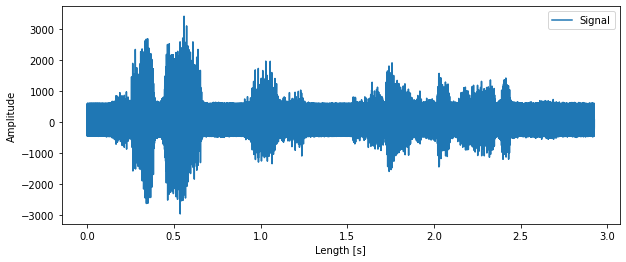

In [4]:
Time = np.linspace(0, np.size(data)/Fs, num=np.size(data))
plt.figure(figsize=(10, 4))
plt.plot(Time, data, label='Signal')
plt.ylabel('Amplitude')
plt.xlabel('Length [s]')
plt.legend()
plt.show()

In [5]:
# normalizing while keeping the original signal data
normalized_data = copy.deepcopy(data)

normalized_data = normalized_data - np.mean(normalized_data)
normalized_data = normalized_data / np.abs(normalized_data).max()

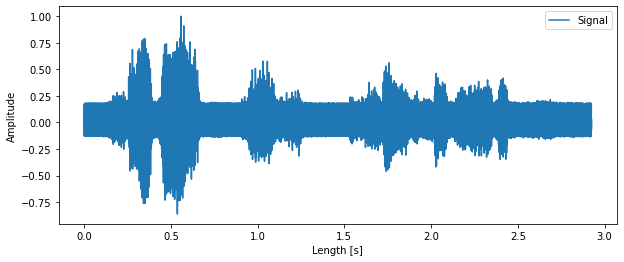

In [6]:
# Graph of normalized data, shape should be same, max amplitude is 1
Time = np.linspace(0, np.size(data)/Fs, num=np.size(data))
plt.figure(figsize=(10, 4))
plt.plot(Time, normalized_data, label='Signal')
plt.ylabel('Amplitude')
plt.xlabel('Length [s]')
plt.legend()
plt.show()

In [7]:
# -1 to discard the last two uncomplete frames, it is not -2 because the list numbering starts from zero
number_of_frames = np.size(data)//512 - 1

In [8]:
# defining matrix of 1024 rows and number_of_frames cols 
matrix = np.zeros((1024, number_of_frames))

In [9]:
# saving frames as columns of matrix
for i in range(0, number_of_frames):
    matrix[:, [i]] = data[i*512: i*512 + 1024].reshape((1024, 1))

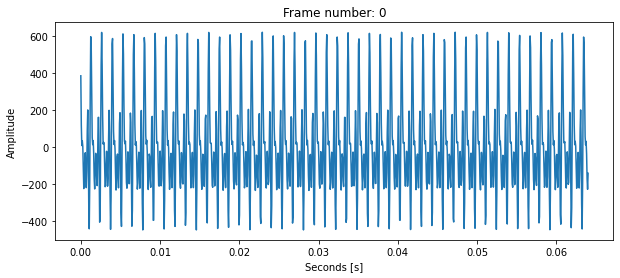

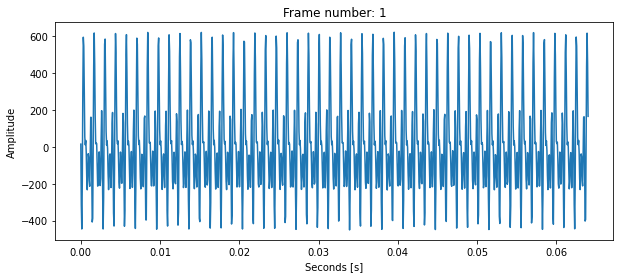

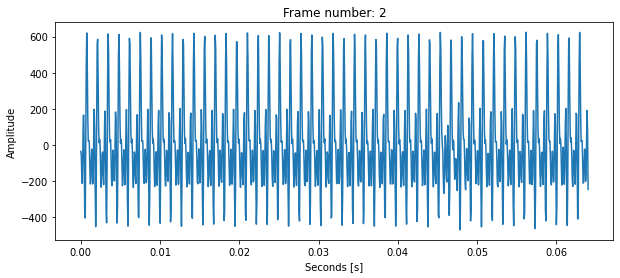

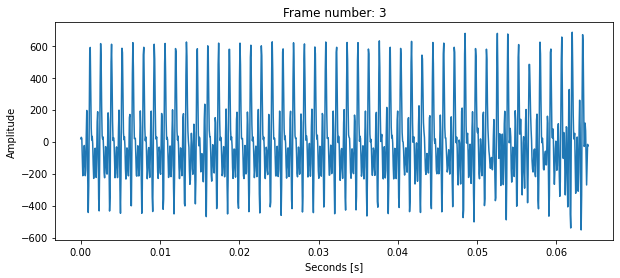

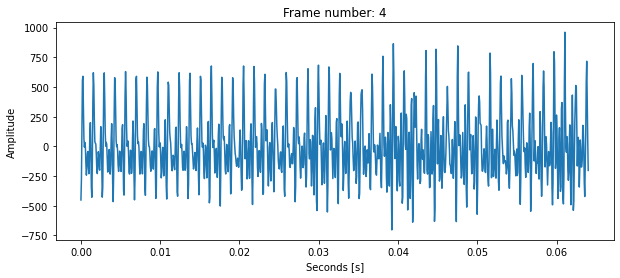

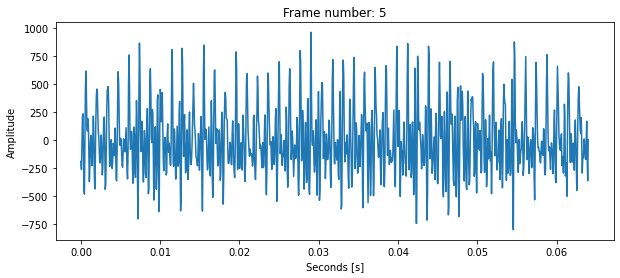

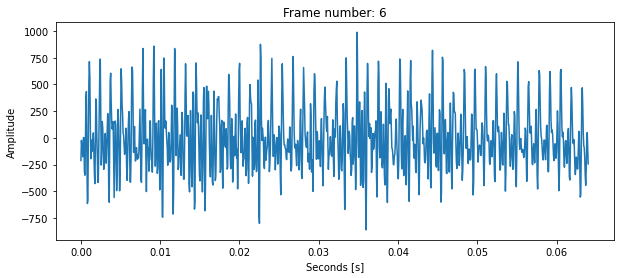

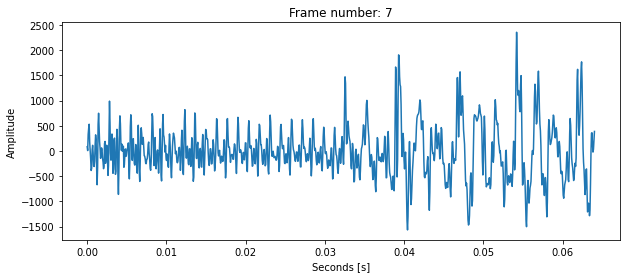

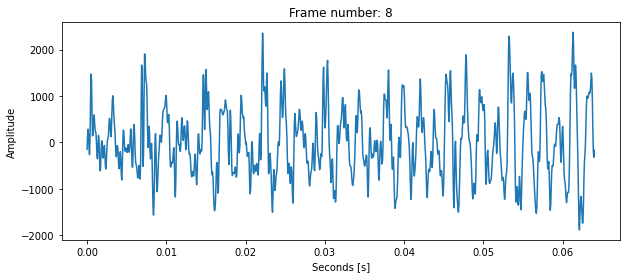

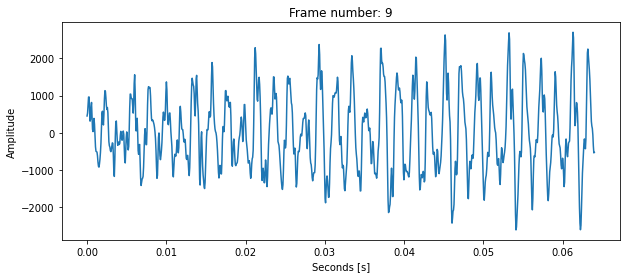

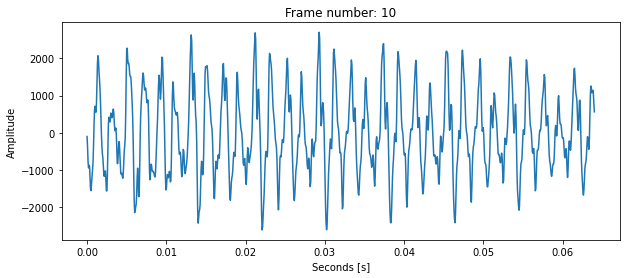

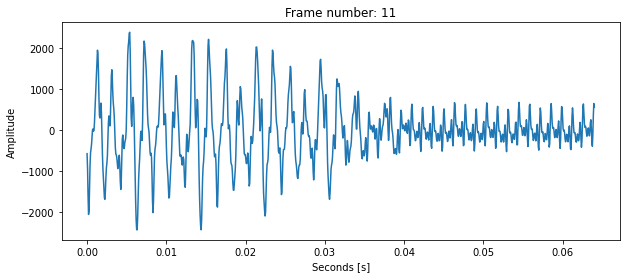

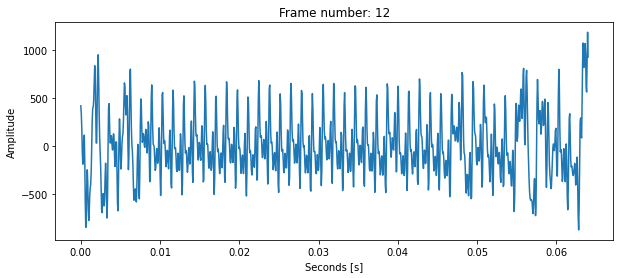

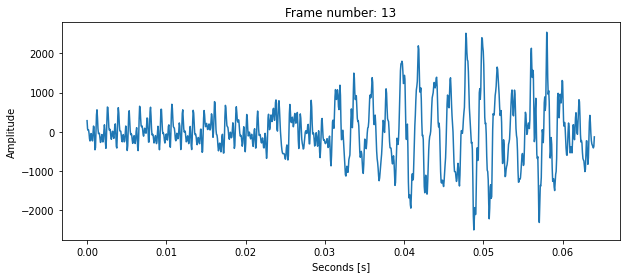

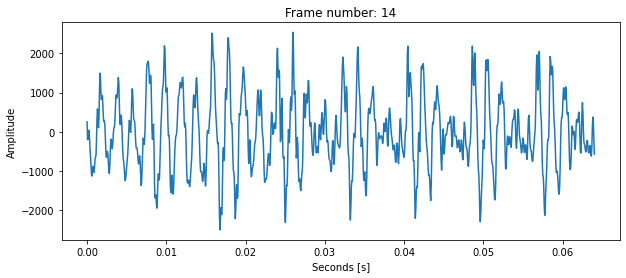

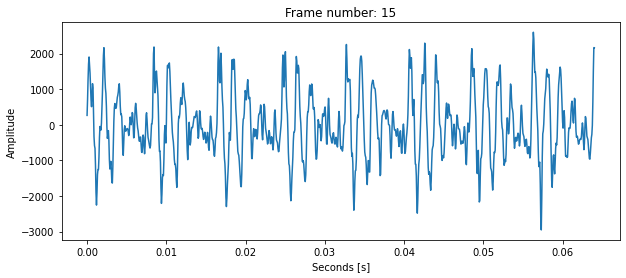

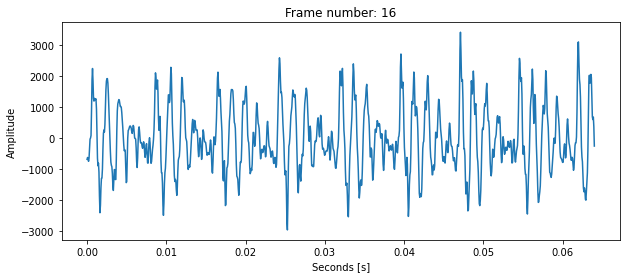

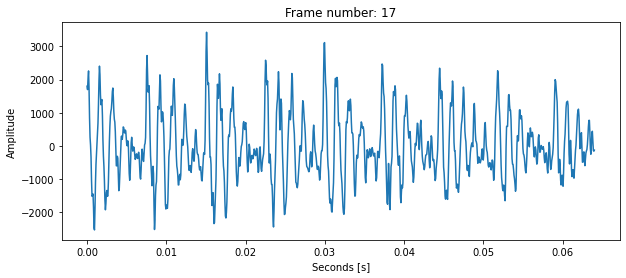

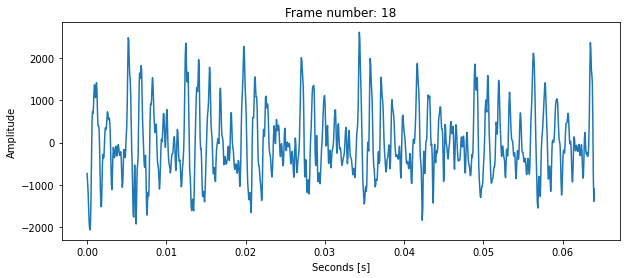

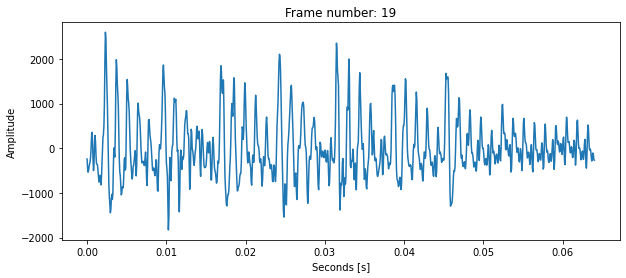

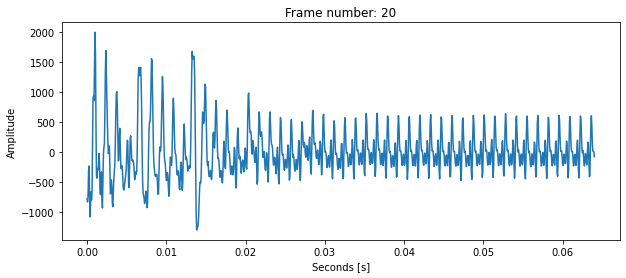

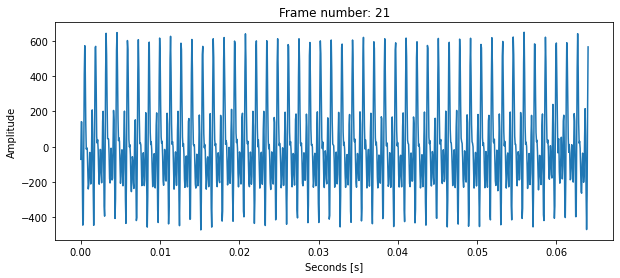

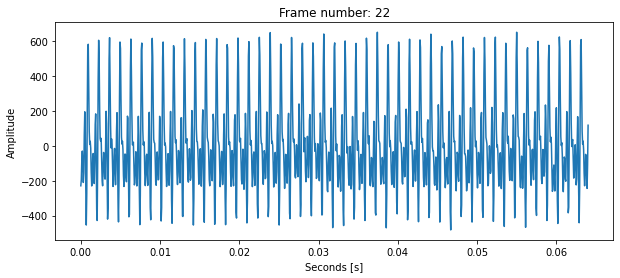

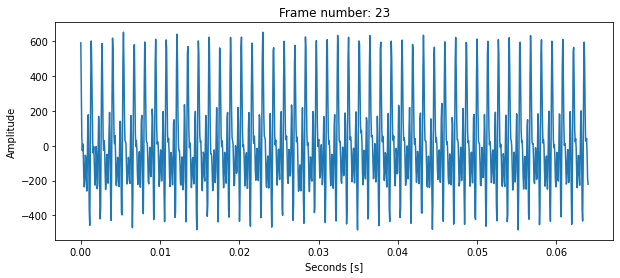

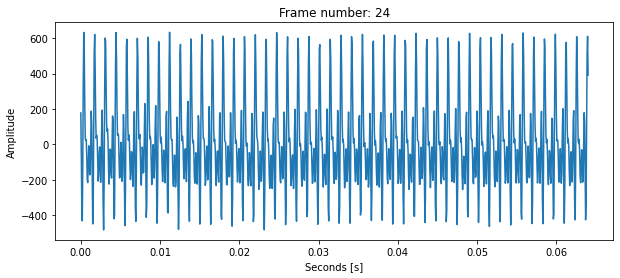

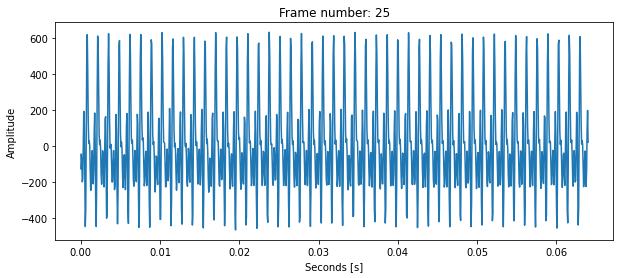

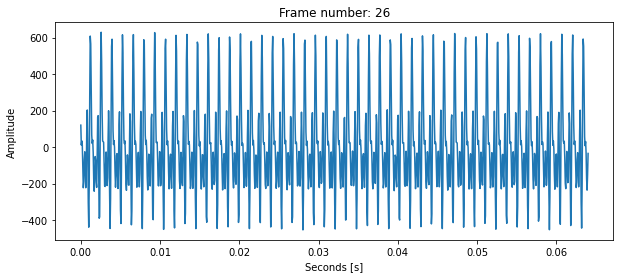

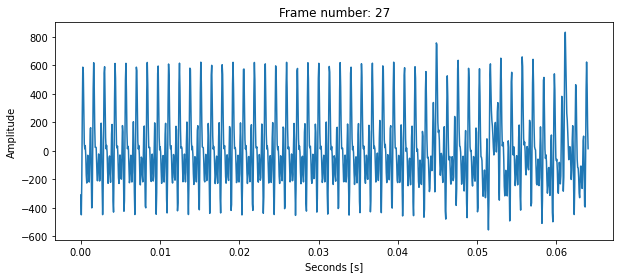

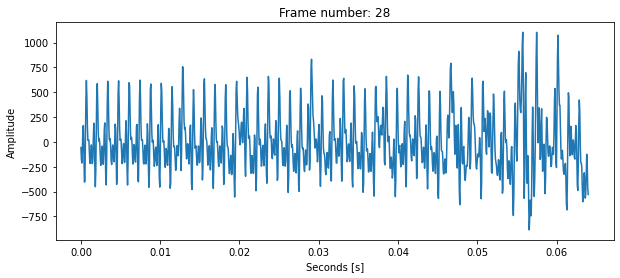

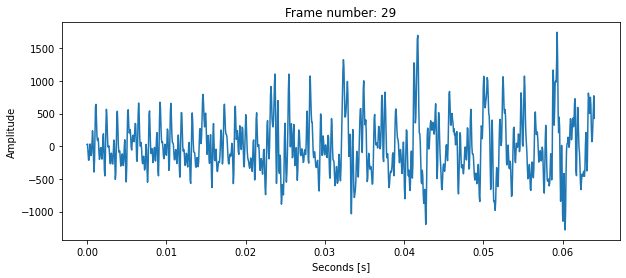

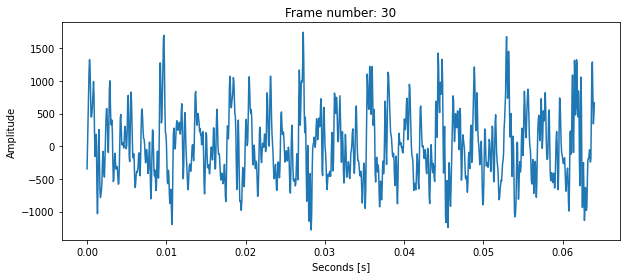

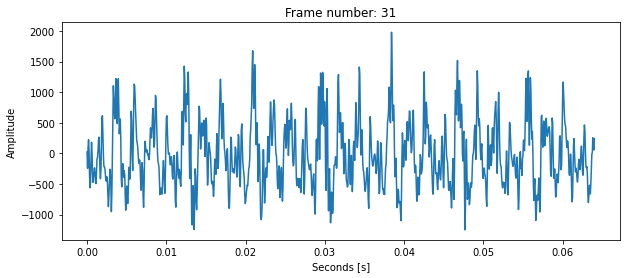

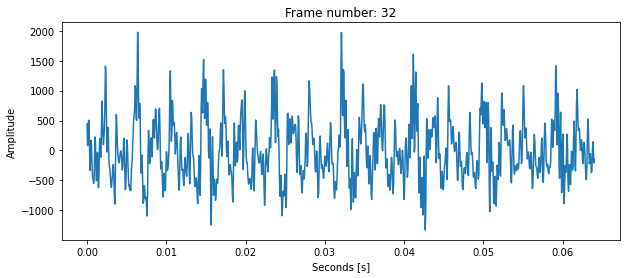

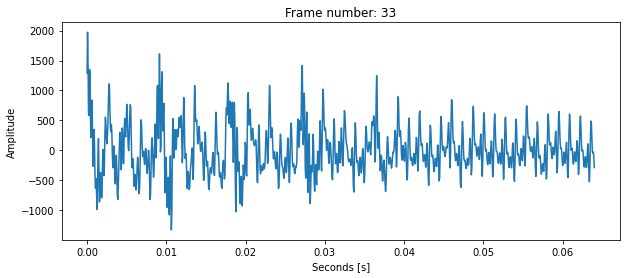

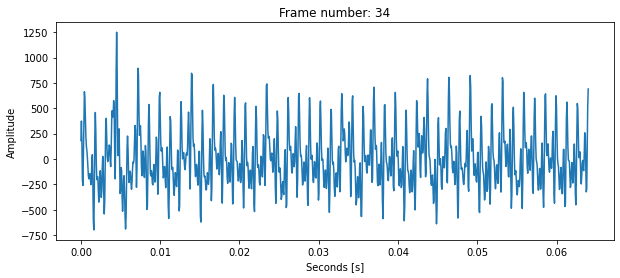

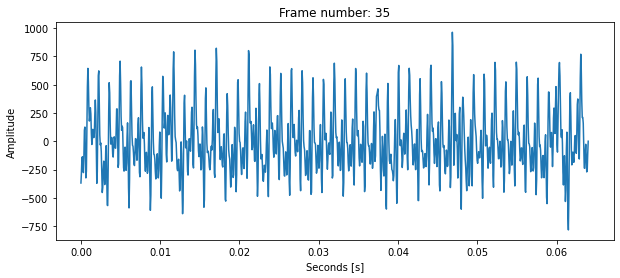

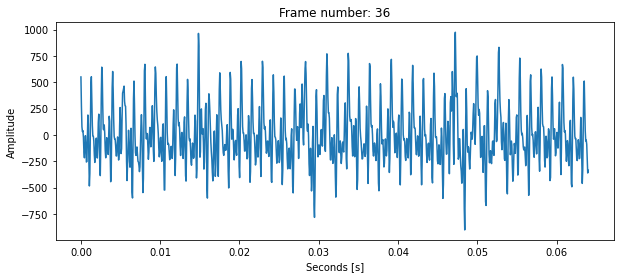

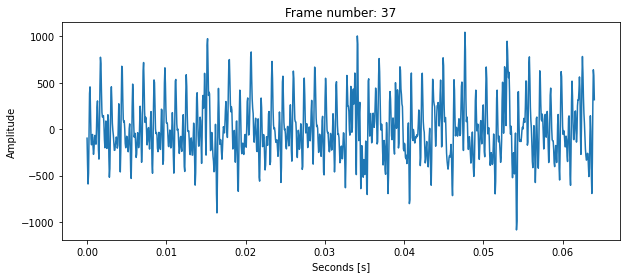

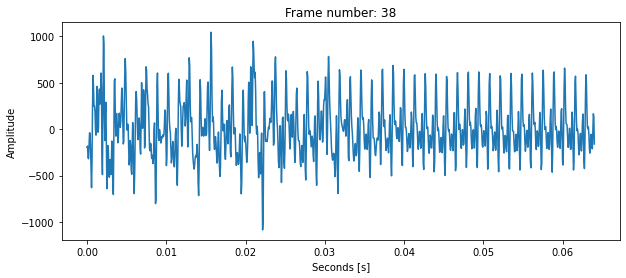

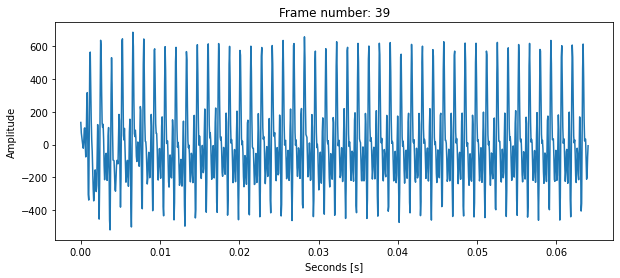

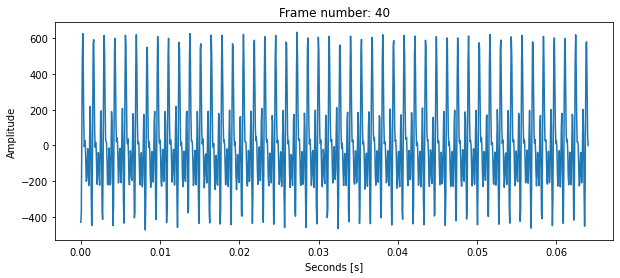

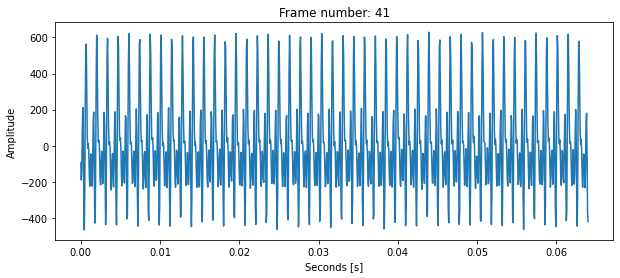

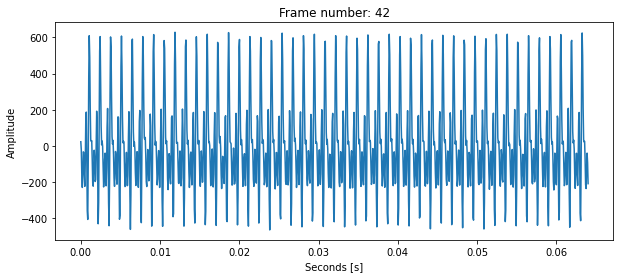

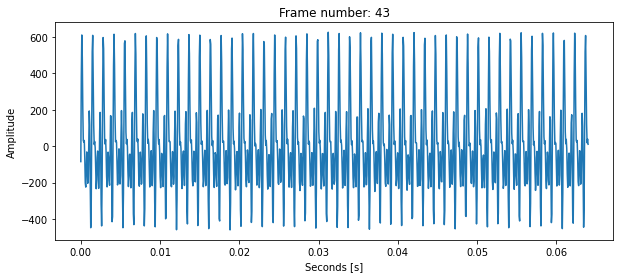

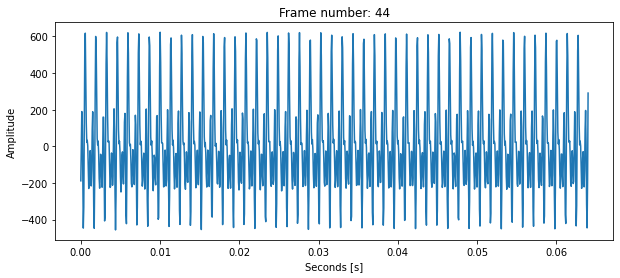

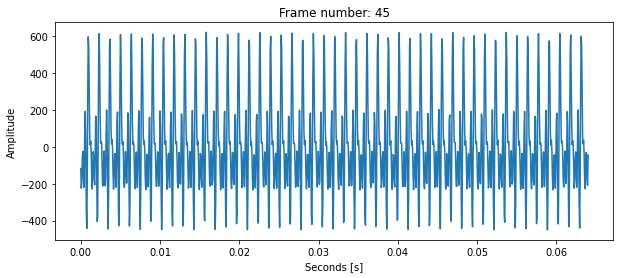

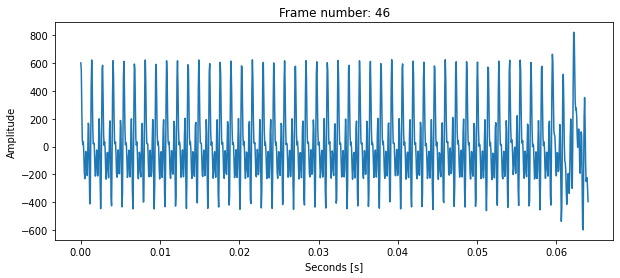

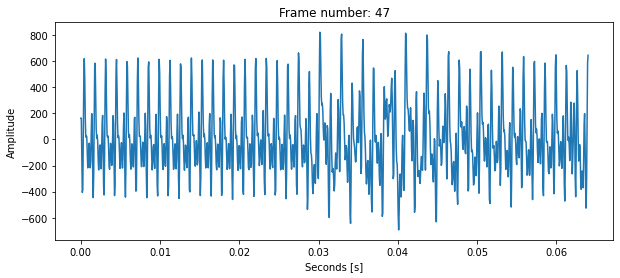

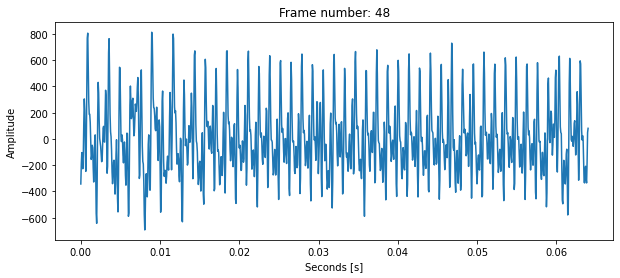

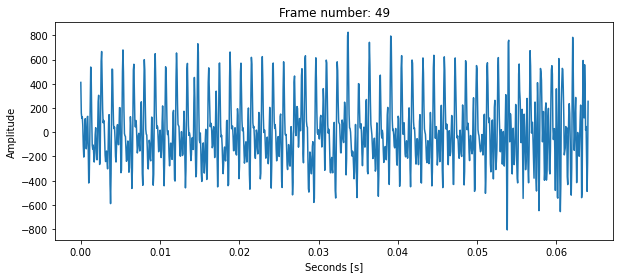

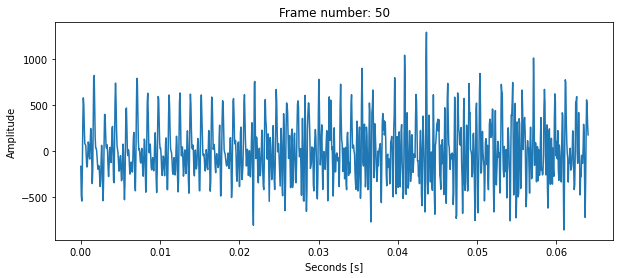

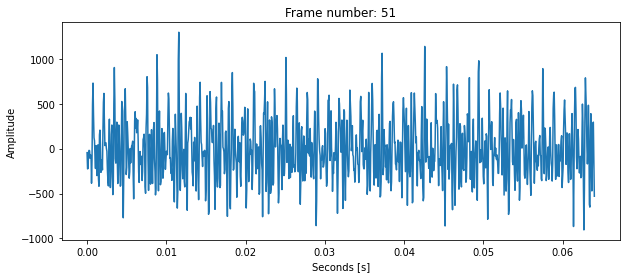

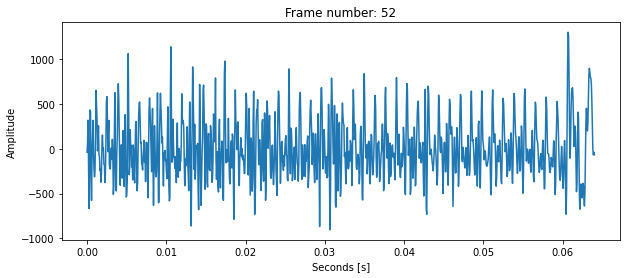

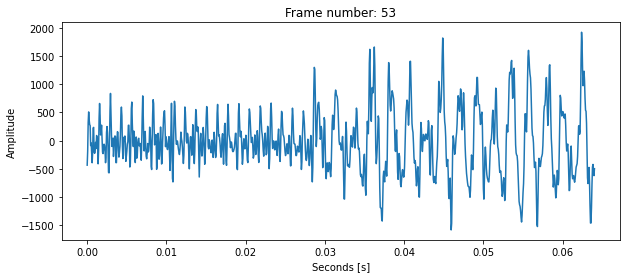

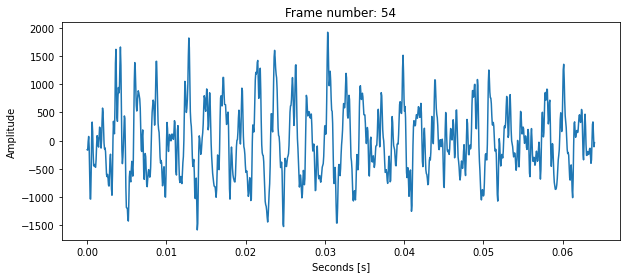

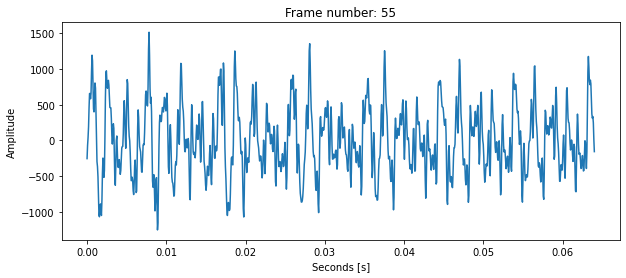

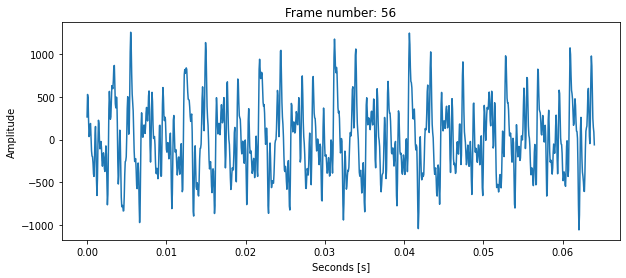

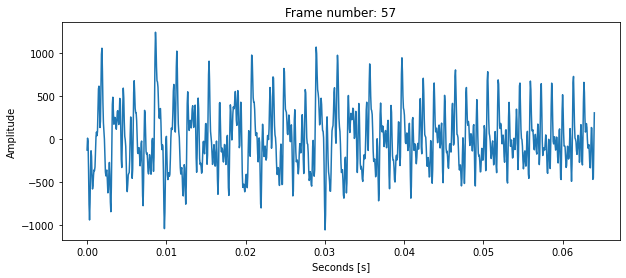

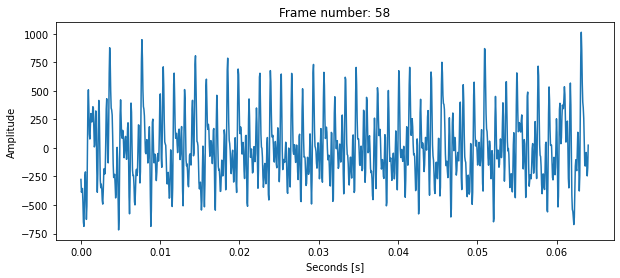

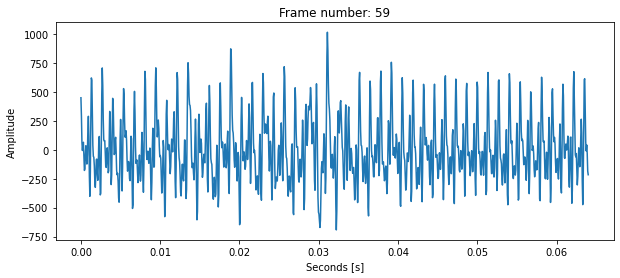

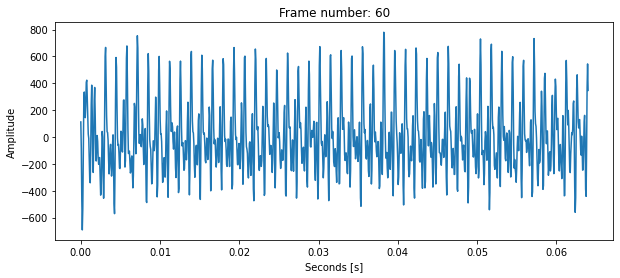

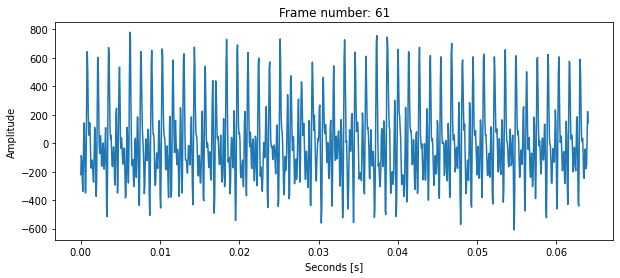

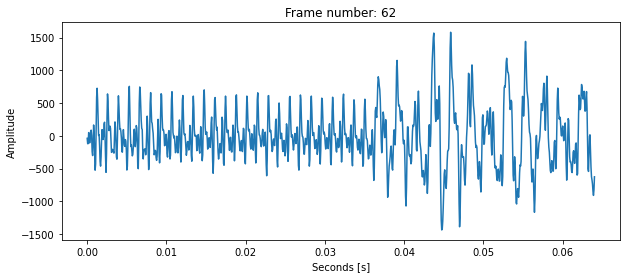

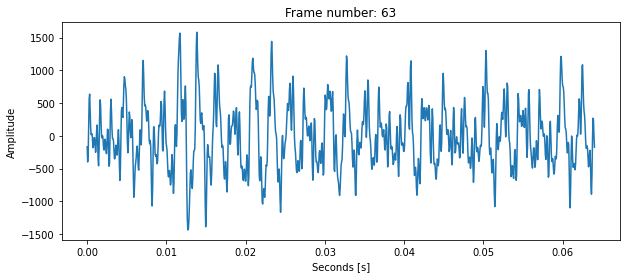

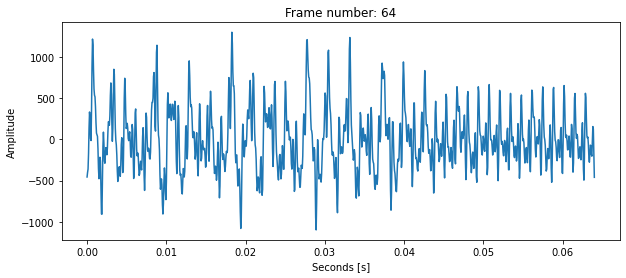

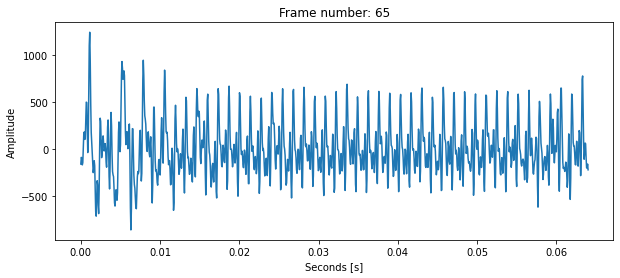

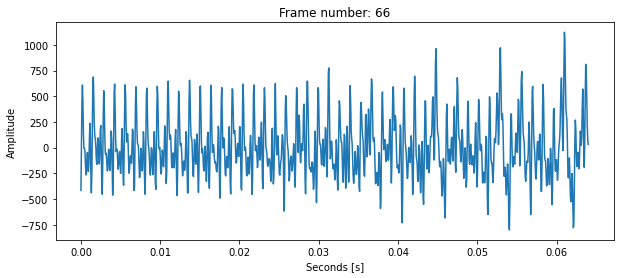

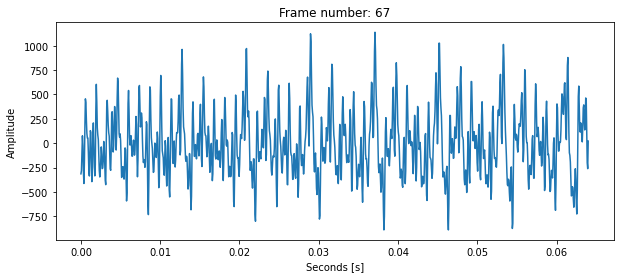

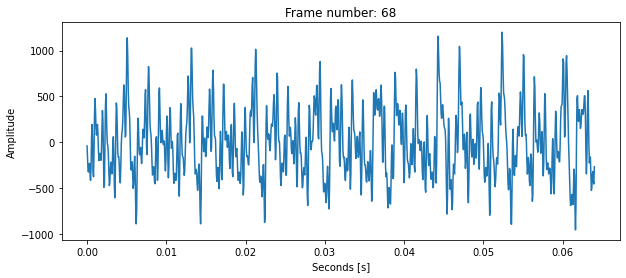

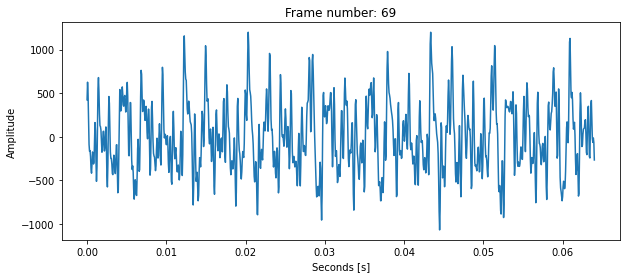

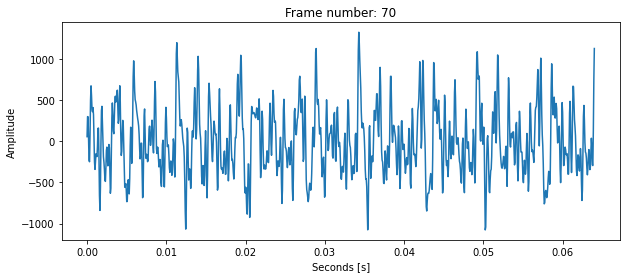

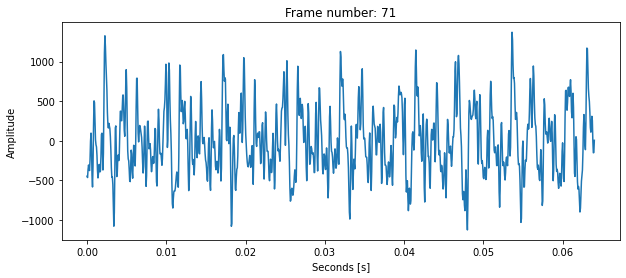

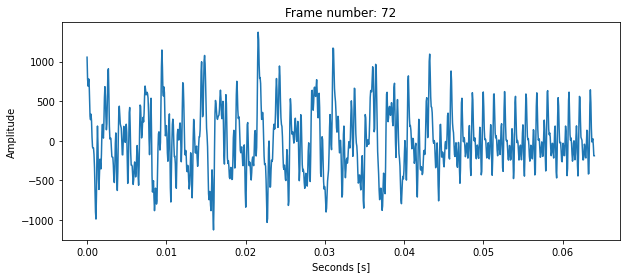

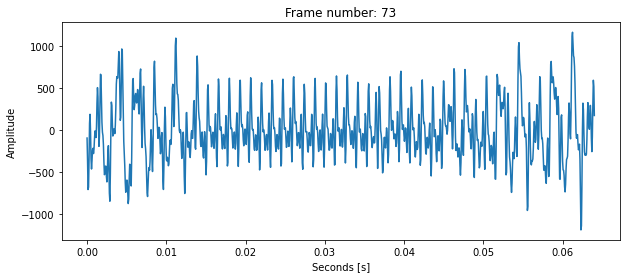

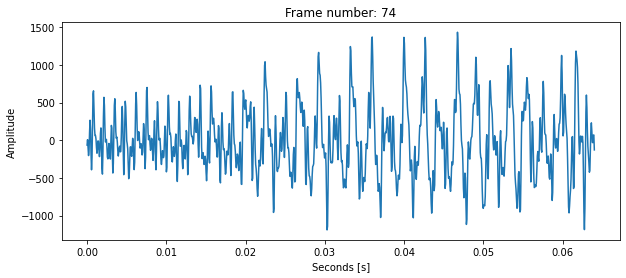

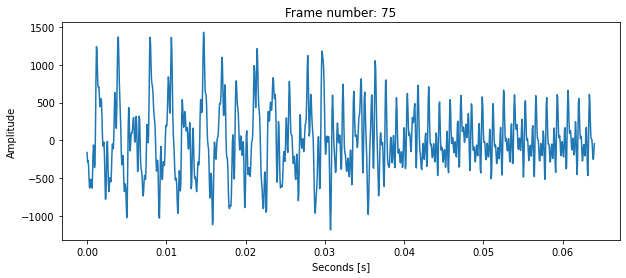

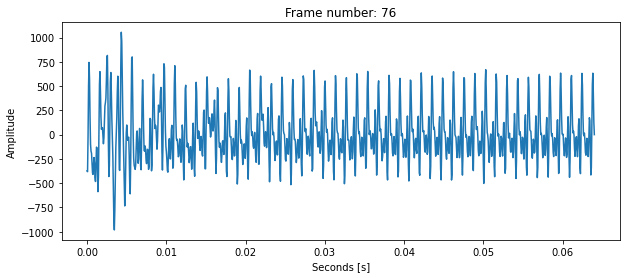

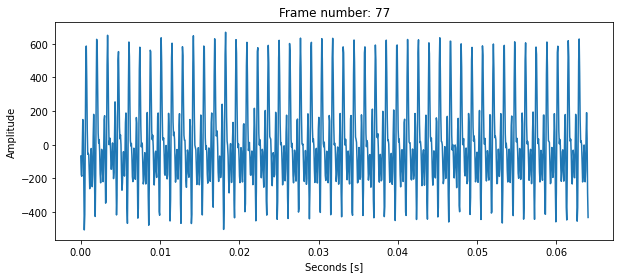

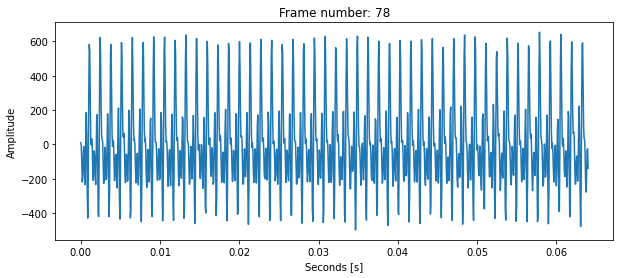

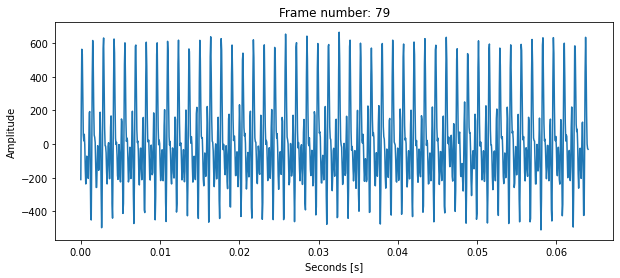

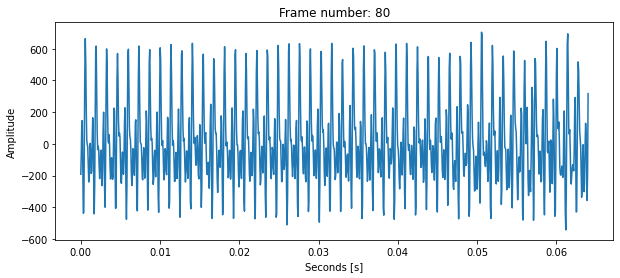

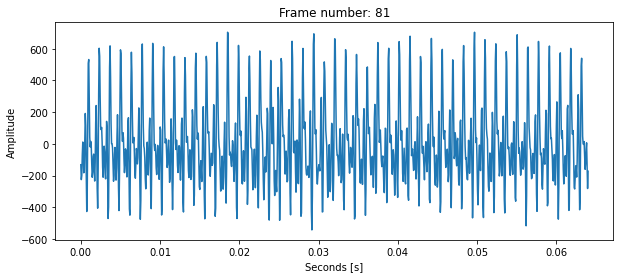

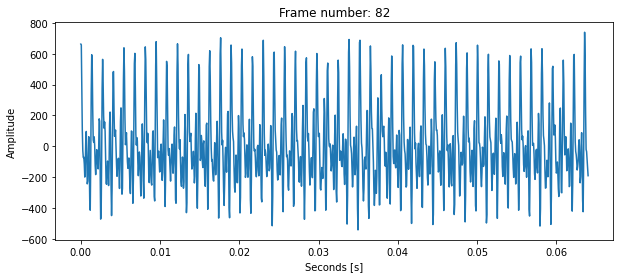

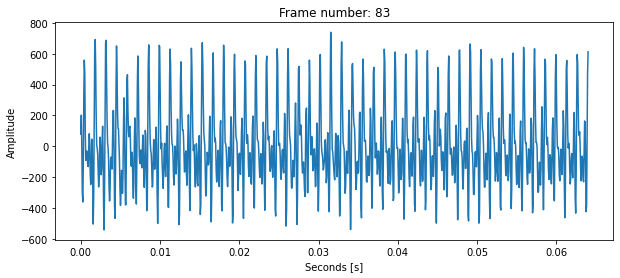

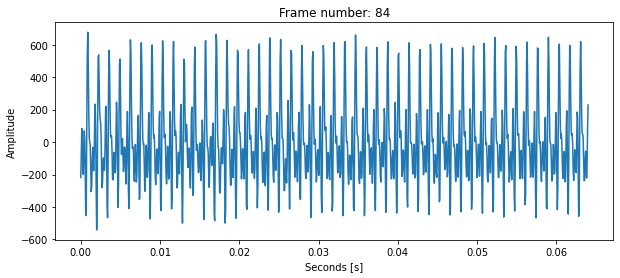

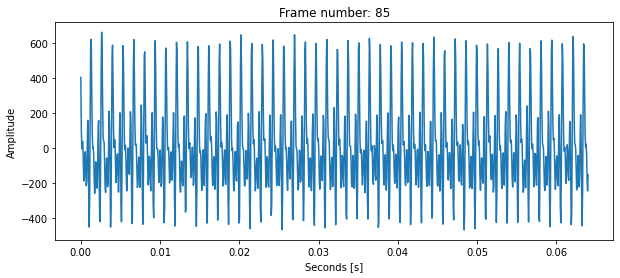

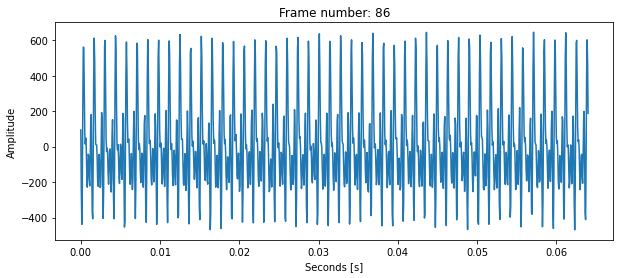

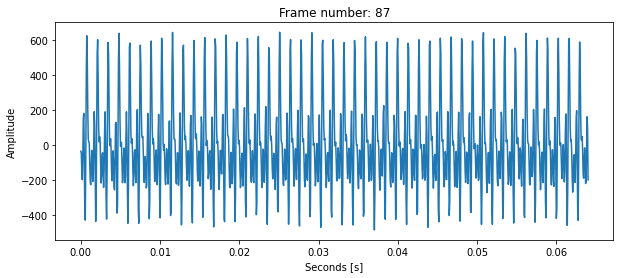

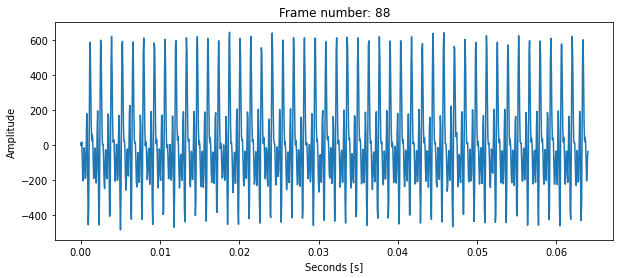

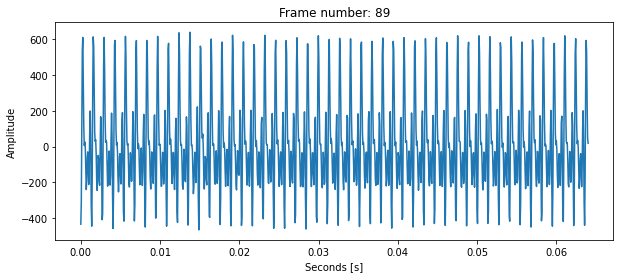

In [10]:
# defining horizontal axis
Time = np.linspace(0, 1024/Fs, num=1024)

# plotting each frame to choose the best (periodic voiced) one
for i in range(number_of_frames):
    plt.figure(figsize=(10, 4))
    plt.title(f"Frame number: {i}")
    plt.plot(Time, matrix[:, [i]])
    plt.ylabel('Amplitude')
    plt.xlabel('Seconds [s]')
    plt.show()

# after thorough consideration, I decided to choose frame no. 17 (18th from the beggining)
frame_number = 17
frame = matrix[:, [frame_number]]


In [11]:
def timeit(f):
    def timed(*args, **kw):
        ts = t.time()
        f(*args, **kw)
        te = t.time()
        print (f"{f.__name__} took: {te-ts} sec")
    return timed

In [12]:
# DFT with my slow DFT implementation

# list for saving N frequency values
X_slow = []
N = 1024
x_values = np.arange(0, N, 1)

@timeit
def my_slow_dft(array):
    global X_slow
    for k in range(0, N):
        X_slow.append(0+0j)
        for n in range(0, N):
            X_slow[k] += array[n][0] * np.exp(-1j*2*np.pi*k*n/N)
            
my_slow_dft(frame)

my_slow_dft took: 3.5282766819000244 sec


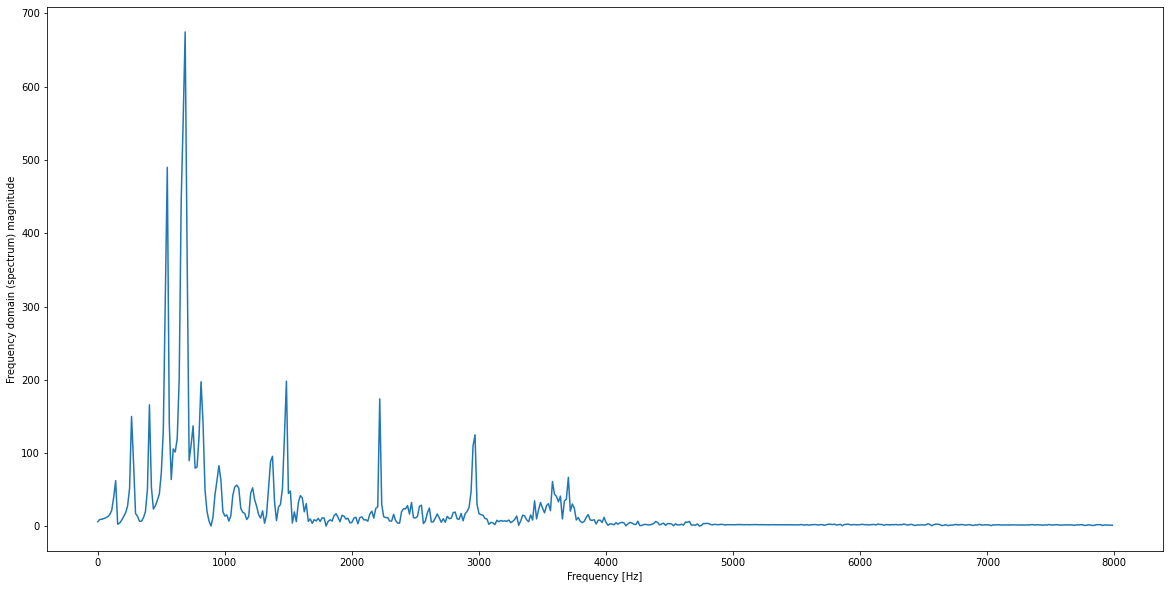

In [33]:
# Plot in frequency domain

# calculating all powers
powers_all_slow = np.abs(np.divide(X_slow, N/2))
# Selecting frequency values 0...N/2
powers_slow = powers_all_slow[0:int(N/2)]

# Adjusting to time domain
frequencies_slow = np.divide(np.multiply(Fs, np.arange(0, N/2)), N)

plt.figure(figsize=(20, 10))
plt.ylabel('Frequency domain (spectrum) magnitude')
plt.xlabel('Frequency [Hz]')
plt.plot(frequencies_slow, powers_slow)
plt.show()

In [14]:
@timeit
def fast_fft(frame):
    global X_fast
    X_fast = np.fft.fft(frame.flatten())

fast_fft(frame)

fast_fft took: 0.00020265579223632812 sec


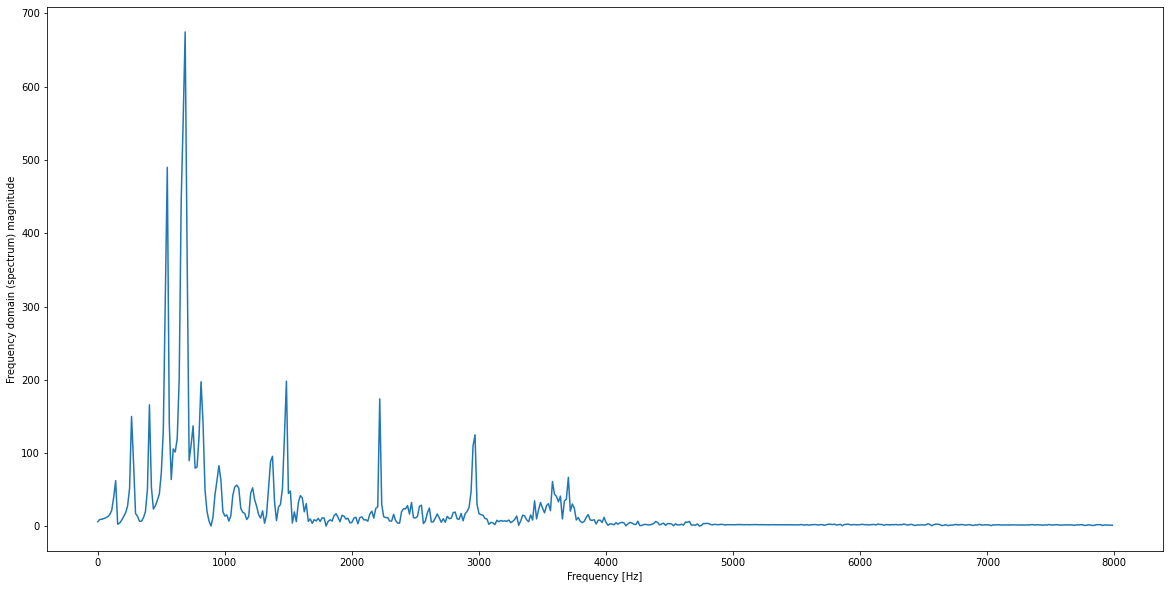

In [15]:
frequencies_fast = np.fft.fftfreq(np.size(frame), d=1/Fs)[0:int(N/2)]

# Plot in frequency domain

# calculating all powers
powers_all_fast = np.abs(np.divide(X_fast, N/2))
# Selecting frequency values 0...N/2
powers_fast = powers_all_fast[0:int(N/2)]

#X_fast_list = X_fast.tolist()

plt.figure(figsize=(20, 10))
plt.ylabel('Frequency domain (spectrum) magnitude')
plt.xlabel('Frequency [Hz]')
plt.plot(frequencies_fast, powers_fast)
plt.show()

In [16]:
# Correlation between DFT implemented by myself and its optimized version from numpy library
print(f"Correlation between two implementations: {np.allclose(X_slow, X_fast, rtol=1e-10)}")

# However the difference in execution time is roughly 3.25s

Correlation between two implementations: True


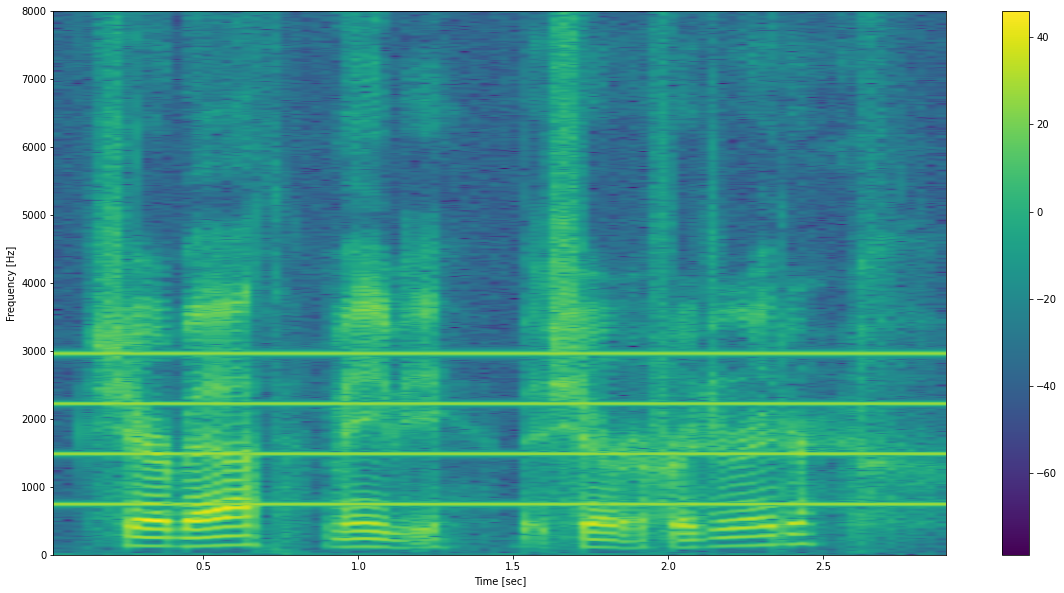

In [65]:
# TODO: dorobit scale na logaritmicky

plt.figure(figsize=(20, 10))
plt.specgram(data, Fs=Fs, NFFT=1024, noverlap=512, mode='psd', scale='dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

# vysledne rusive frekvencie vyzeraju byt harmonicky vztazene. Prva je na frekvencii 740Hz
base_freq = 740

In [66]:
# spectogram od zmolikovej

# f, t, sgr = signal.spectrogram(data, Fs)
# # prevod na PSD
# sgr_log = 10 * np.log10(sgr+1e-20) 

# plt.figure(figsize=(20, 10))
# plt.pcolormesh(t,f,sgr_log, shading='auto')
# plt.gca().set_xlabel('Čas [s]')
# plt.gca().set_ylabel('Frekvencia [Hz]')
# cbar = plt.colorbar()
# cbar.set_label('Spektrálna hustota výkonu [dB]', rotation=270, labelpad=15)


# plt.tight_layout()

In [67]:
t = np.arange(np.size(data))
m = 740

cos1 = 0.5*np.cos(2*(np.pi/Fs)*1*m*t)
cos2 = 0.5*np.cos(2*(np.pi/Fs)*2*m*t)
cos3 = 0.5*np.cos(2*(np.pi/Fs)*3*m*t)
cos4 = 0.5*np.cos(2*(np.pi/Fs)*4*m*t)

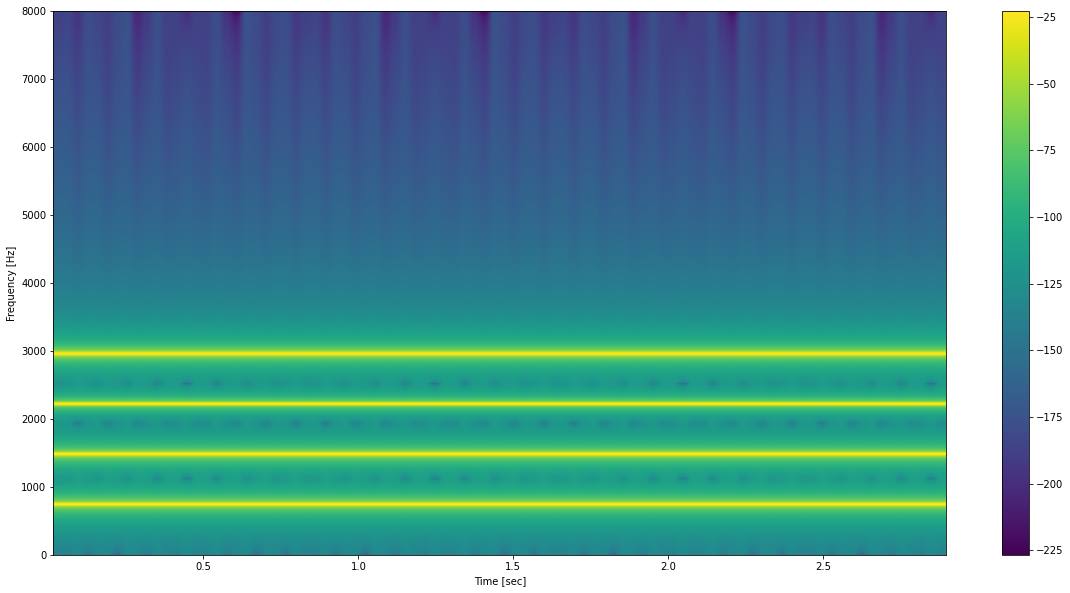

In [68]:
cos = cos1 + cos2 + cos3 + cos4
plt.figure(figsize=(20, 10))
plt.specgram(cos, Fs=Fs, NFFT=1024, noverlap=512, mode='psd', scale='dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

In [69]:
wav.write('/home/pavel/iss-project/audio/1.wav', Fs, cos1)

In [51]:
frame_size = 1024
shift = 512

frames = np.array([data[i*shift:i*shift + frame_size] for i in range(len(data) //shift - frame_size//shift + 1)])
filtered_X = np.array([np.abs(np.fft.fft(x)) for x in frames])

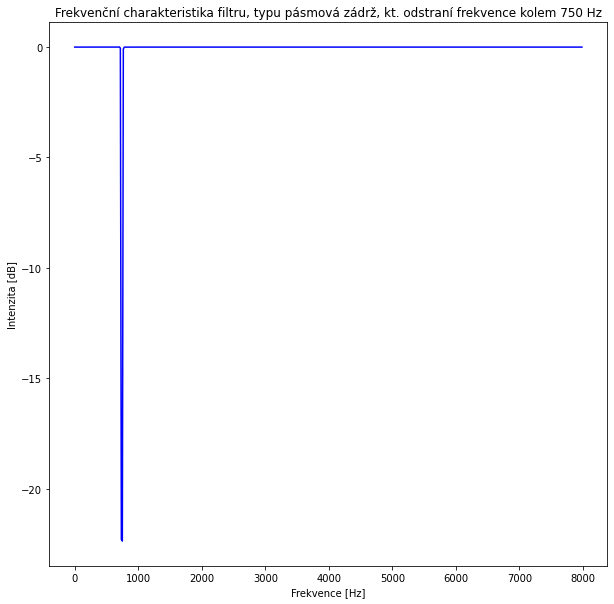

(1024,)


In [94]:
# source: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_bandstop(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a  = butter(order, [low, high], btype='bandstop')
    return b, a

def butter_bandstop_filter(data, lowcut, highcut, fs, order=5):
    a, b= butter_bandstop(lowcut, highcut, fs, order=order)

    y = lfilter(b, a, data)
    return y

filter_width = 15 # 1/2 filter width

spectras = []
frame = filtered_X[frame_number]
spectras.append(frame)
plt.figure(figsize=(10,10))

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html
#compute the frequency response
w, h = signal.freqz(*butter_bandstop(base_freq-filter_width, base_freq+filter_width, Fs))

plt.plot(w/np.pi*Fs/2, 20 * np.log10(abs(h)), 'b')
plt.title('Frekvenční charakteristika filtru, typu pásmová zádrž, kt. odstraní frekvence kolem 750 Hz')
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Intenzita [dB]')
plt.show()

xfilts = []
xfilts.append(data)
x_filt = copy.deepcopy(data)

for band_f in range(740,3100,740):
    # returns filtered data
    x_filt = butter_bandstop_filter(x_filt, band_f-filter_width, band_f+filter_width, Fs)
    
    xfilts.append(x_filt)
    frame = np.abs(np.fft.fft(x_filt[frame_number*shift:frame_number*shift + frame_size], n=1024))
    spectras.append(frame)
    
print(spectras[0].shape)

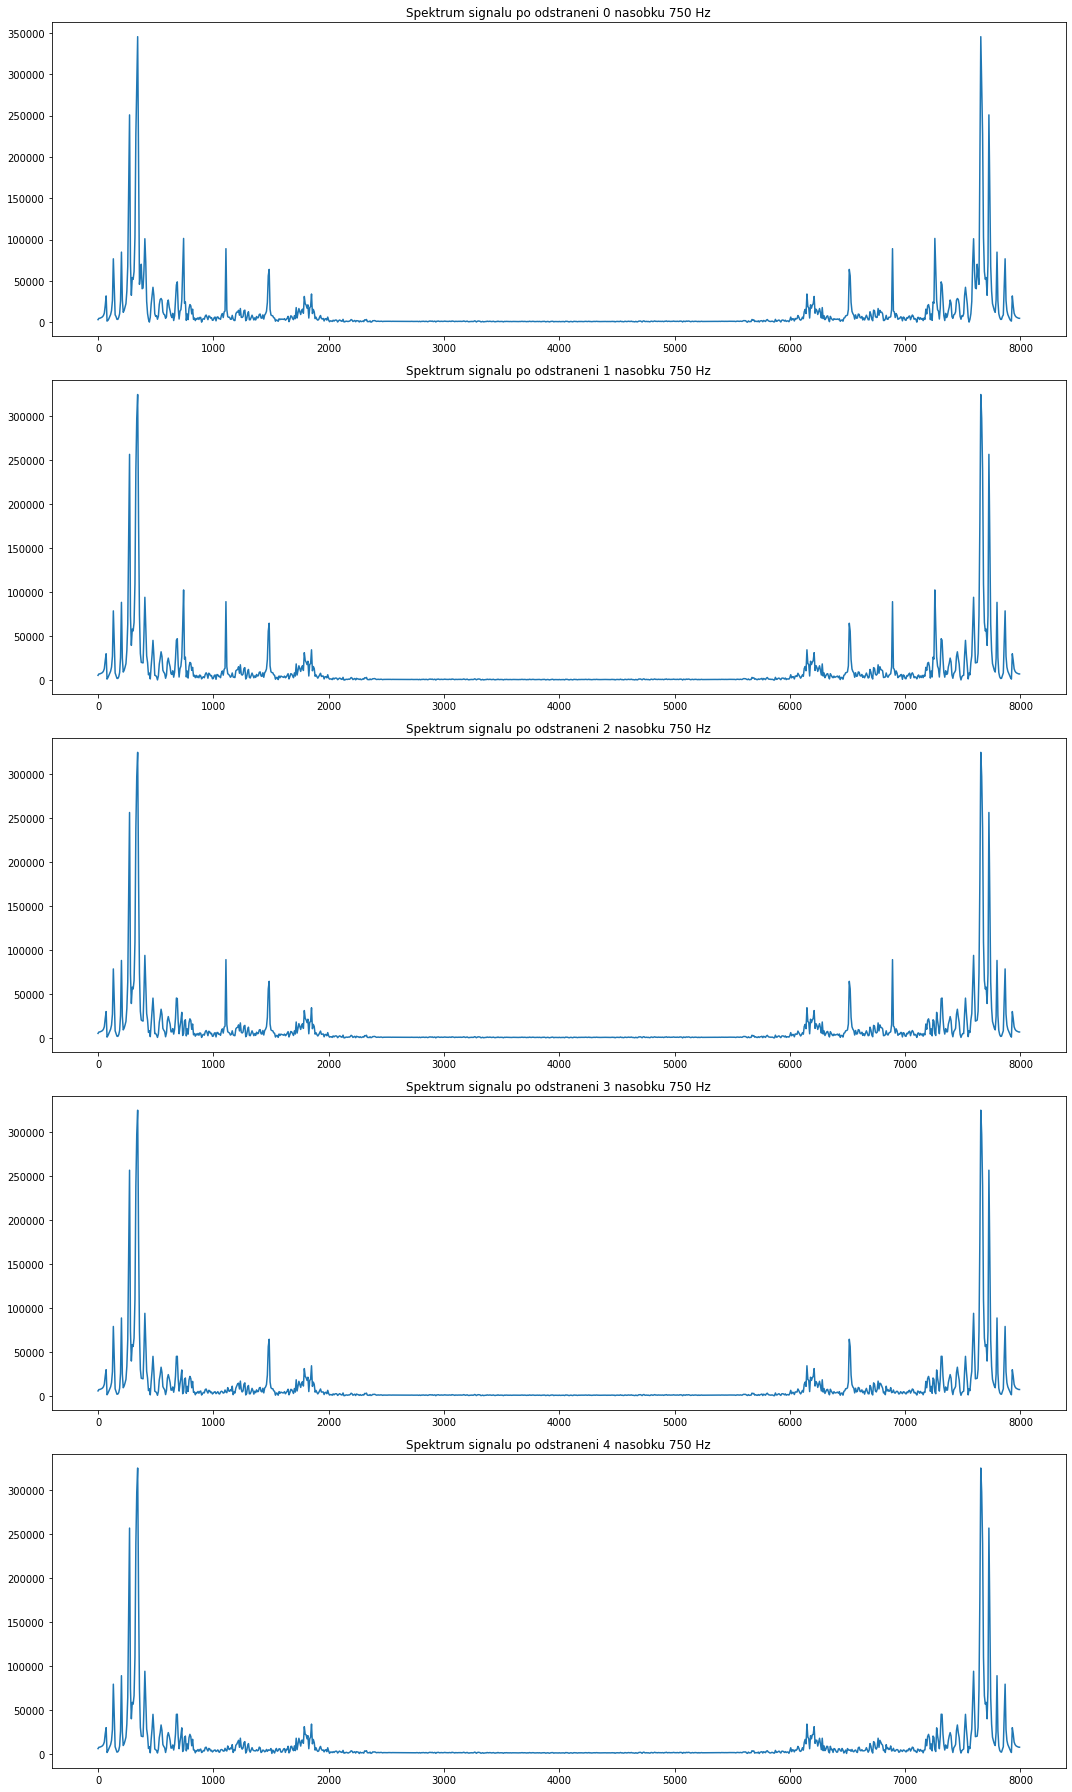

In [64]:
f, ax = plt.subplots(len(spectras), figsize=(15, len(spectras)*5))
for s in range(len(spectras)):
    ax[s].set_title(f'Spektrum signalu po odstraneni {s} nasobku 750 Hz')
    ax[s].plot(np.arange(frame_size)/frame_size * Fs/2, spectras[s].T)
plt.tight_layout()
plt.show()

## from IPython.display import Audio

In [50]:
Audio(data=xfilts[0], rate=Fs)

In [27]:
Audio(data=xfilts[1], rate=Fs)

In [28]:
Audio(data=xfilts[2], rate=Fs)

In [29]:
Audio(data=xfilts[3], rate=Fs)

In [30]:
Audio(data=xfilts[4], rate=Fs)

In [31]:
wav.write('/home/pavel/iss-project/audio/filtered.wav', Fs, np.multiply(xfilts[4], 0.0005)) # multiply kvoli hlasitosti

NameError: name 'null_points' is not defined

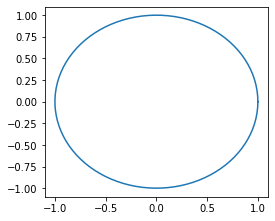

In [32]:
plt.figure(figsize=(4,3.5))

# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(null_points), np.imag(null_points), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(null_points_conj), np.imag(null_points_conj), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper right')

plt.tight_layout()



In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8,3))

times = np.linspace(0, 2*np.pi/Fs,9)
ax[0].plot(times, np.abs(filter_coefs))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(times, filter_coefs)
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()



In [ ]:
f0 = 740.0  # Frequency to be removed from signal (Hz)
Q = 10.0  # Quality factor

# Design notch filter
b, a = signal.iirnotch(f0, Q, Fs)

# Frequency response
freq, h = signal.freqz(b, a, fs=Fs)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")

ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])

ax[1].grid()
plt.show()

